In [1]:
import jax
from jax import numpy as jnp, random as jr, value_and_grad, tree_util

import optax

import numpy as np
import matplotlib.pyplot as plt

from env import Env
from svae.inference import make_gradfun
from svae.utils import split_into_batches
from svae.network import init_mlp, identity, make_loglike
from svae.models.hmm import run_inference, init_pgm_param, rollout, onehot_sample

In [2]:
key = jr.PRNGKey(0)
num_epochs, num_datapoints, batch_dim, num_steps = 2000, 5000, 64, 8

env = Env()
data_key, key = jr.split(key)
data, actions = env.sample(data_key, num_datapoints, num_steps)
data = data.reshape(num_datapoints, num_steps, -1)

batch_key, key = jr.split(key)
(data_batches, action_batches), num_batches = split_into_batches(batch_key, (data, actions), batch_dim)
get_batch = lambda i: data_batches[i % num_batches]
get_action_batch = lambda i: action_batches[i % num_batches]

In [3]:
def rollout_images(params, data, actions, key):
    samples_key, key = jr.split(key)
    pgm_params, decoder_params, encoder_params = params
    node_potentials = encoder(encoder_params, data)
    logits = rollout(pgm_params, node_potentials, actions)
    samples = onehot_sample(logits, samples_key)
    return decoder(decoder_params, samples)


def infer_images(params, prior_params, data, actions, key):
    infer_key, key = jr.split(key)
    pgm_params, decoder_params, encoder_params = params
    node_potentials = encoder(encoder_params, data)
    samples, _, _, _ = run_inference(infer_key, prior_params, pgm_params, node_potentials, 1, actions)
    return decoder(decoder_params, samples)


def test(params, prior_params, data, actions, env, key):
    idx = np.random.randint(data.shape[0])
    test_data = data[idx : idx + 1, :]
    test_actions = actions[idx : idx + 1, :]
    decoded_infer = infer_images(params, prior_params, test_data, test_actions, key)

    test_data_0, test_actions = test_data[0, 0, :], test_actions[0, :]
    decoded_rollout = rollout_images(params, test_data_0, test_actions, key)

    env.plot_sample(test_data.reshape(-1, 10, 10), test_actions)
    env.plot_sample(decoded_infer.reshape(-1, 10, 10))
    env.plot_sample(decoded_rollout.reshape(-1, 10, 10))

    probs = params[0][1] / jnp.sum(params[0][1], axis=-1, keepdims=True)
    fig, axs = plt.subplots(1, 4)
    for i in range(4):
        axs[i].imshow(probs[i])
        axs[i].axis("off")
    plt.show()

epoch 0: 69.19


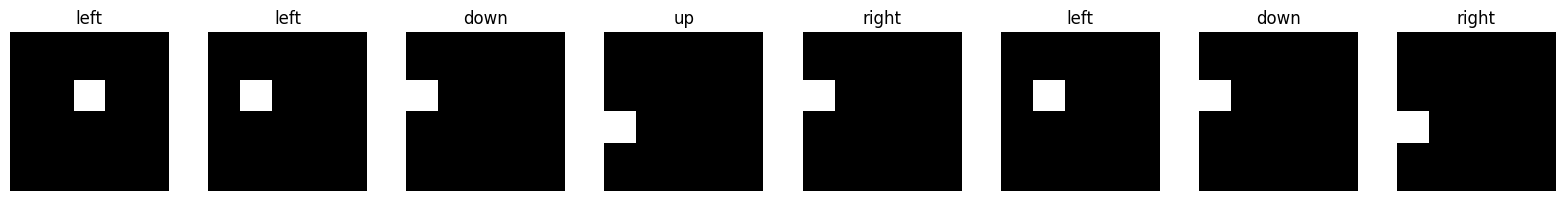

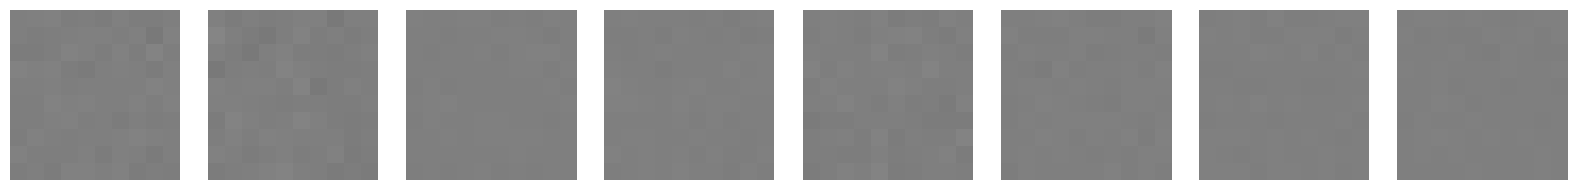

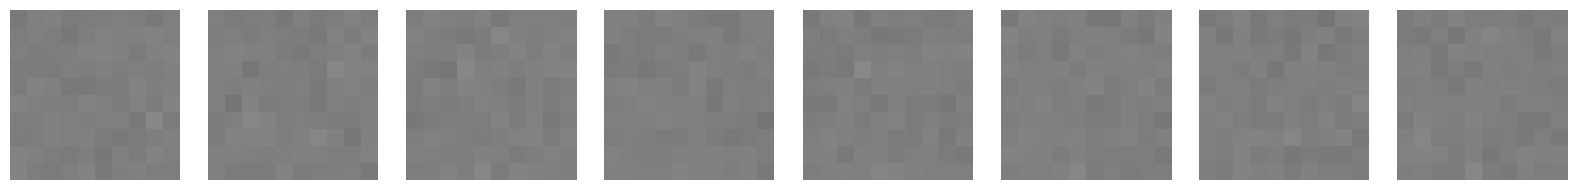

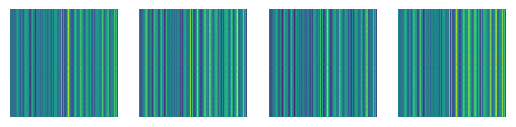

epoch 200: 9.95


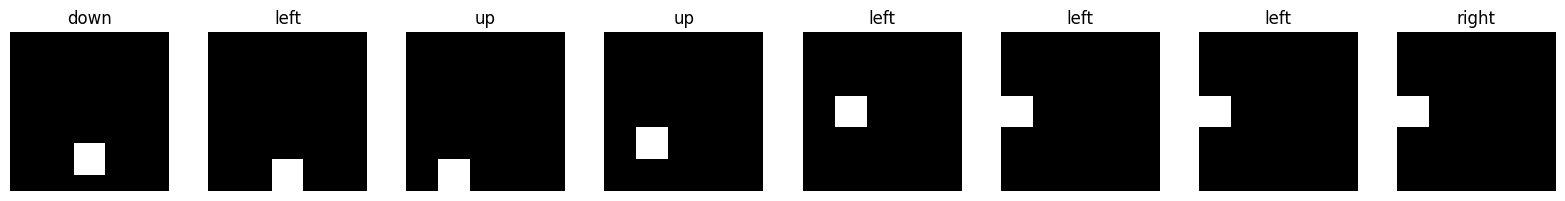

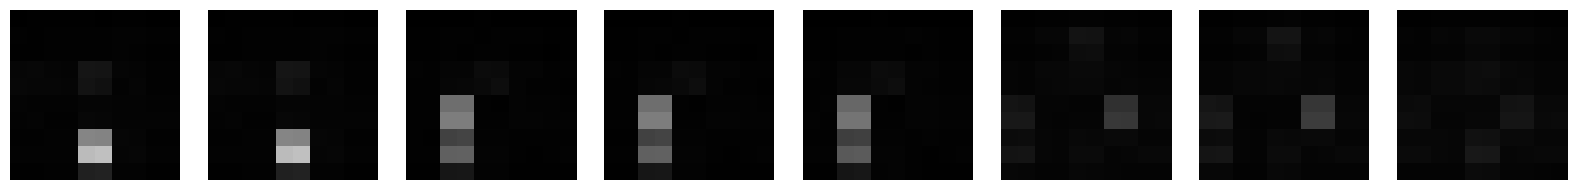

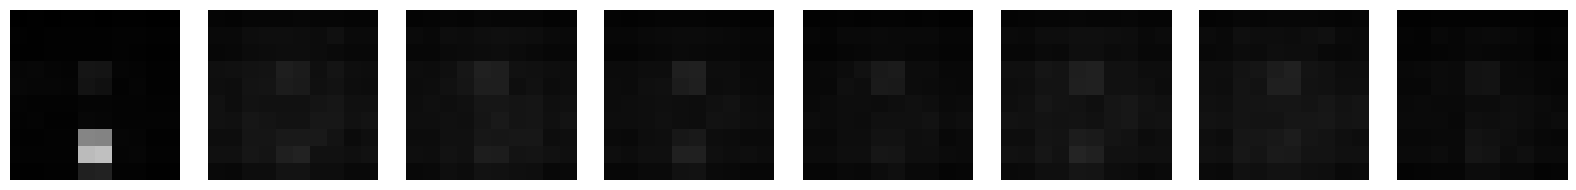

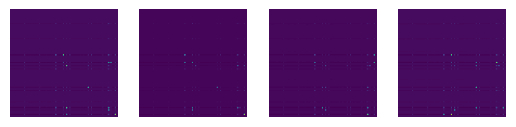

epoch 400: 8.03


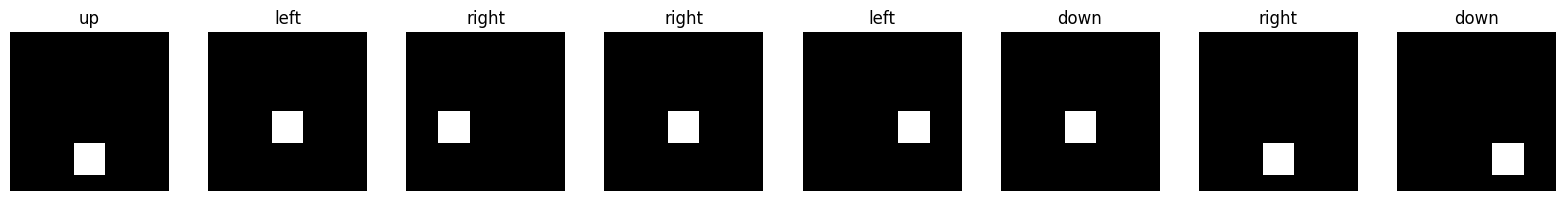

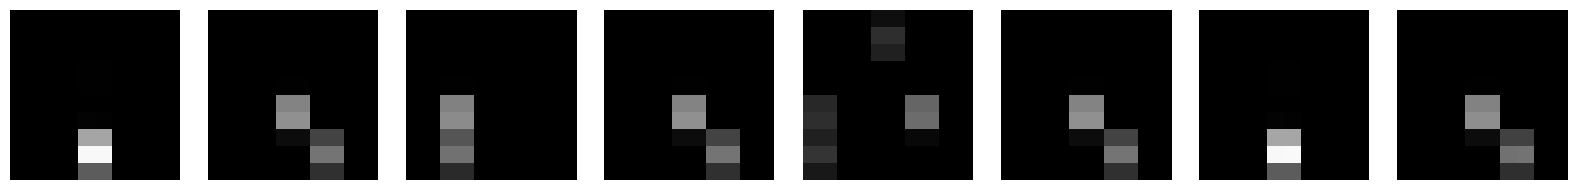

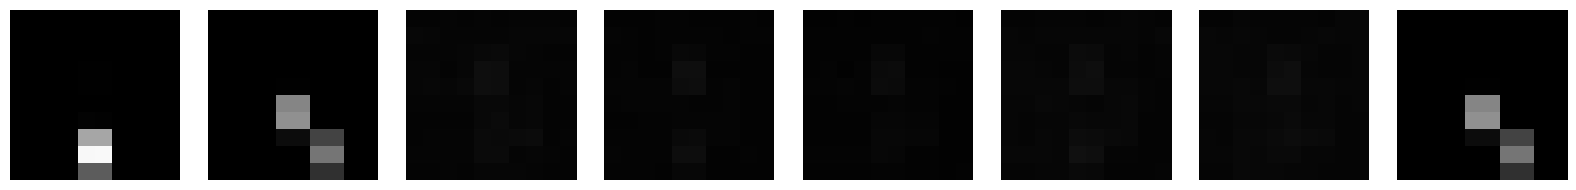

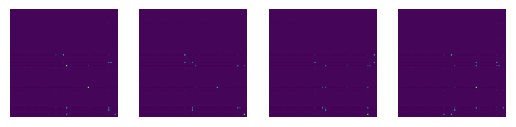

epoch 600: 6.90


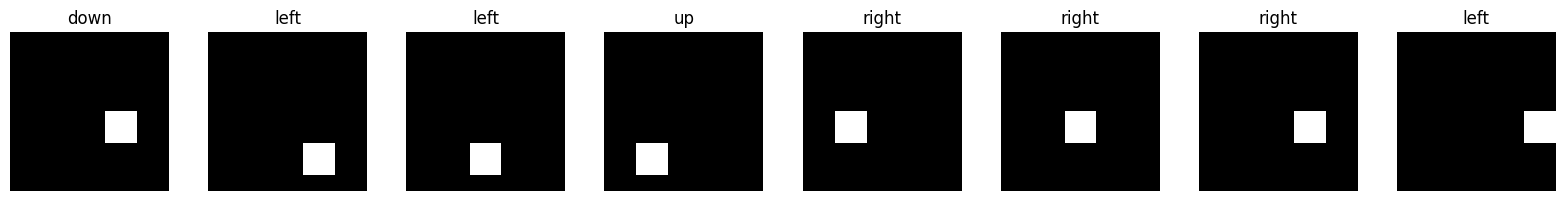

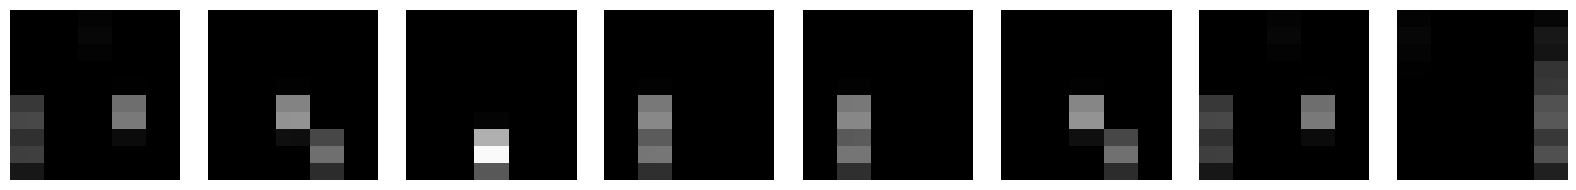

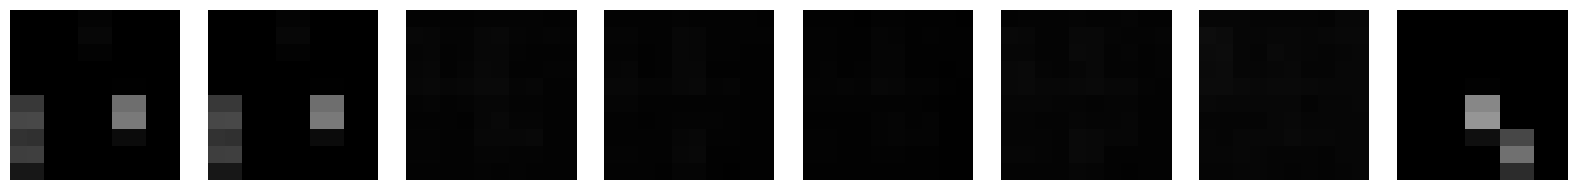

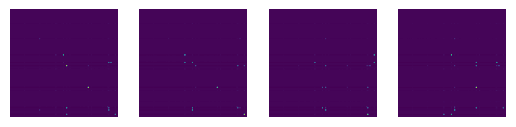

epoch 800: 6.45


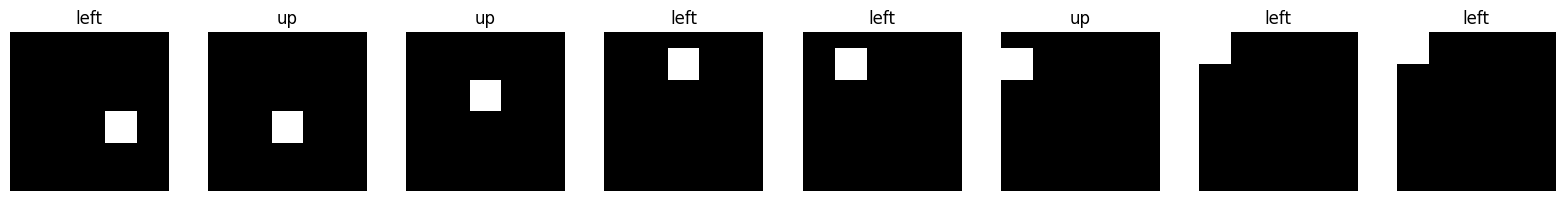

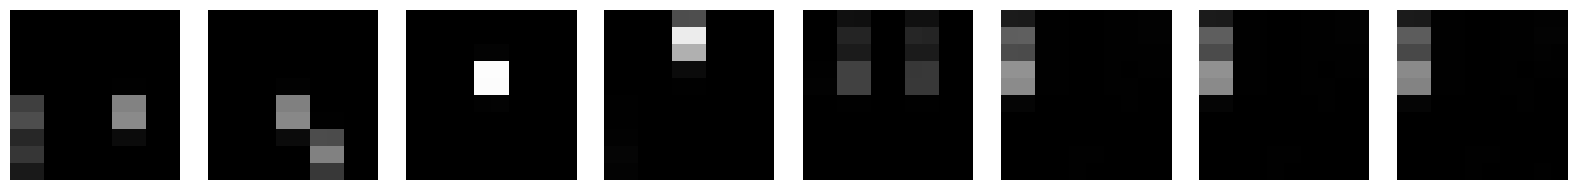

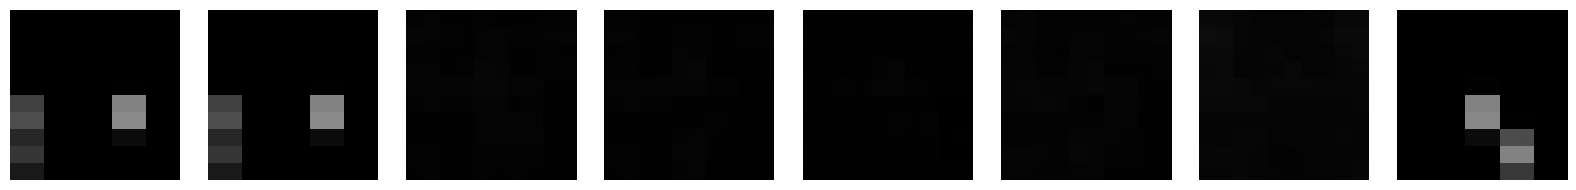

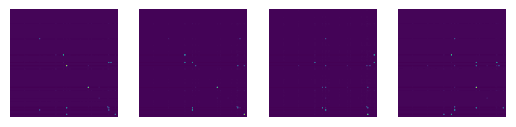

epoch 1000: 5.09


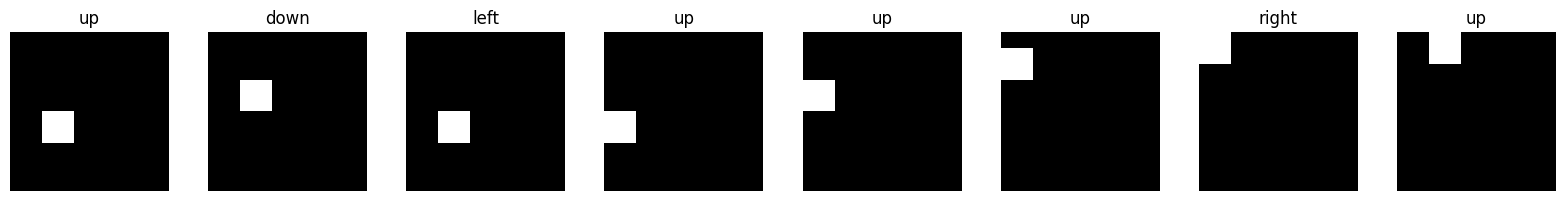

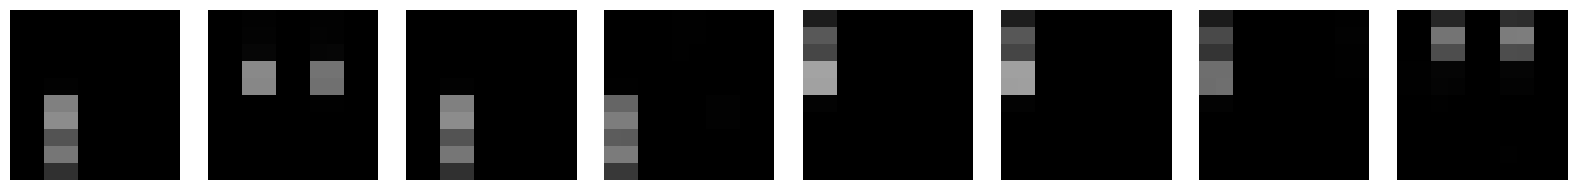

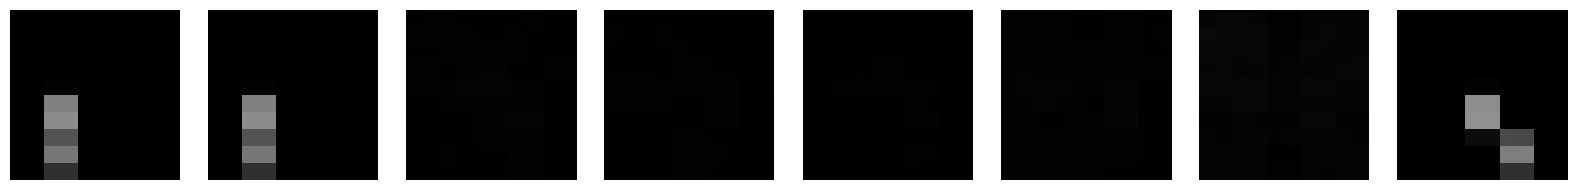

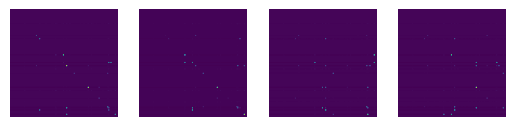

epoch 1200: 4.79


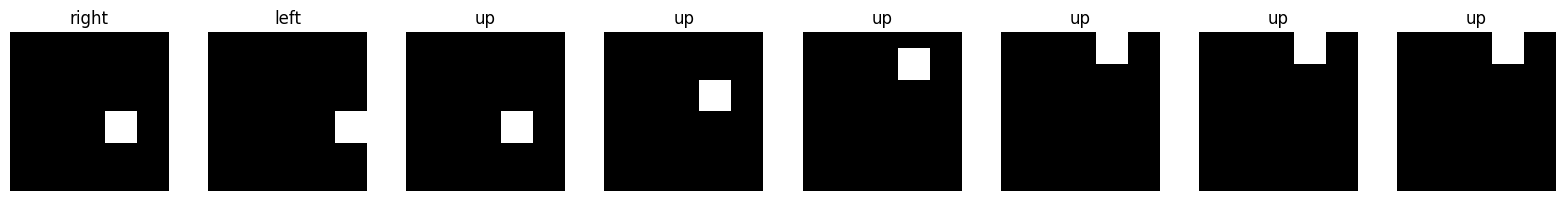

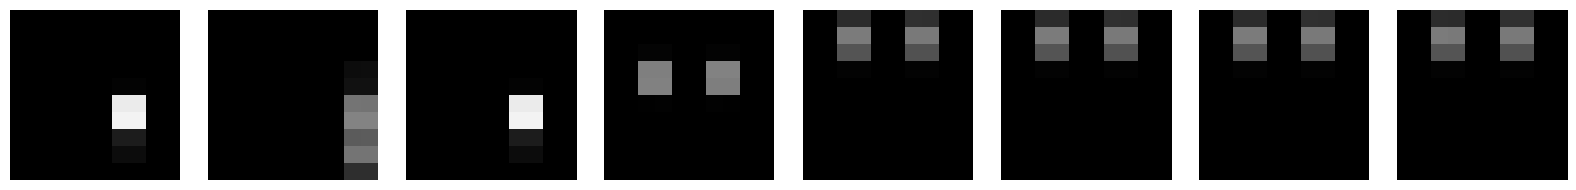

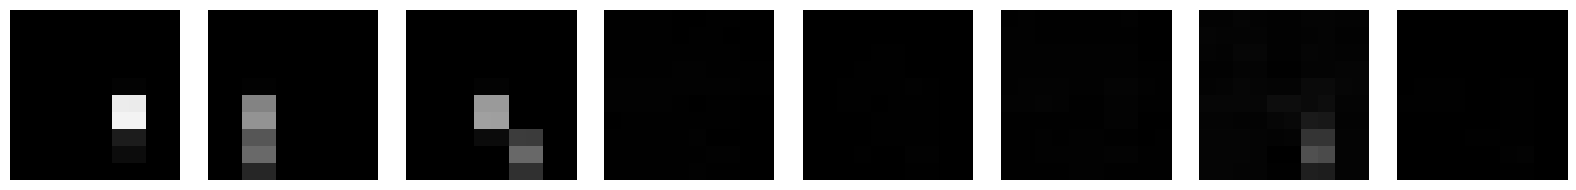

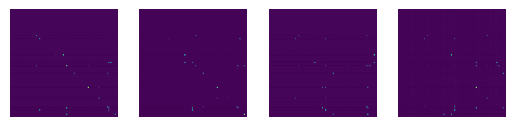

epoch 1400: 3.79


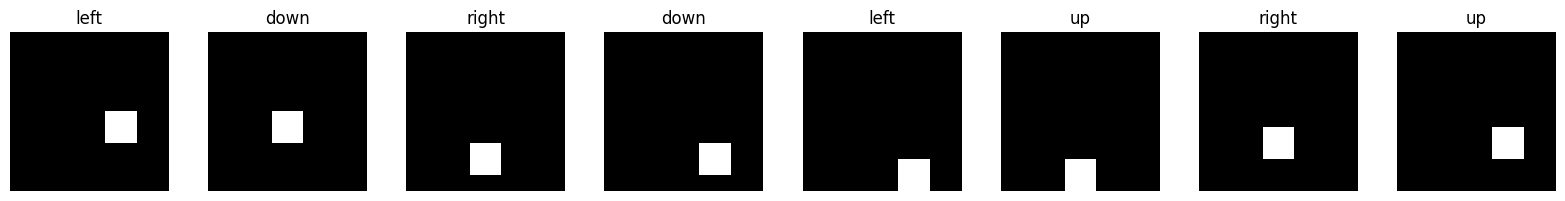

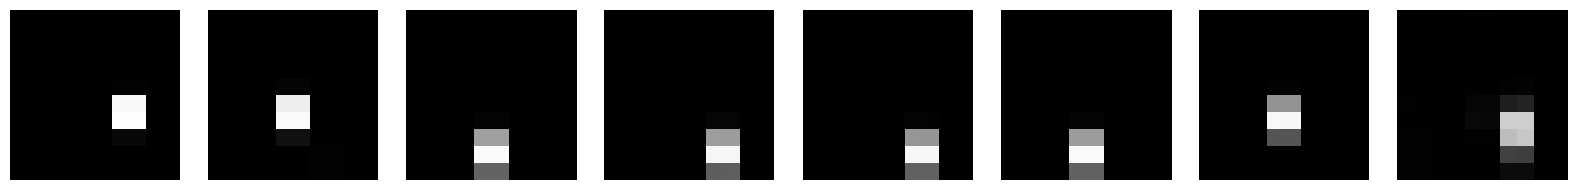

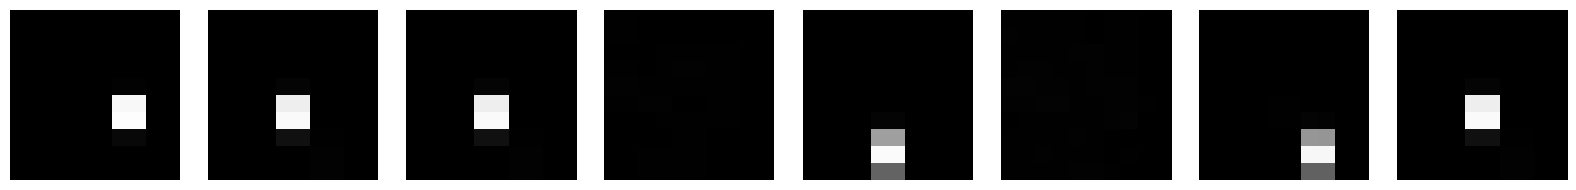

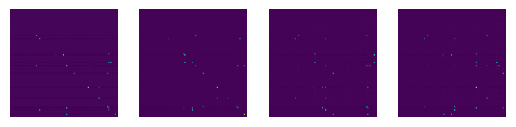

epoch 1600: 2.37


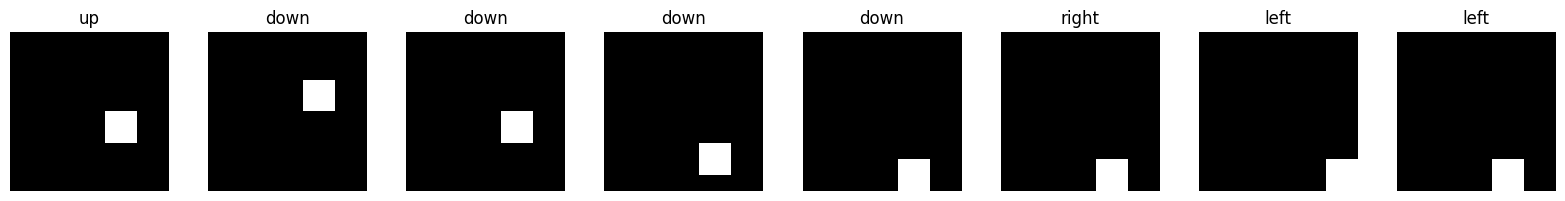

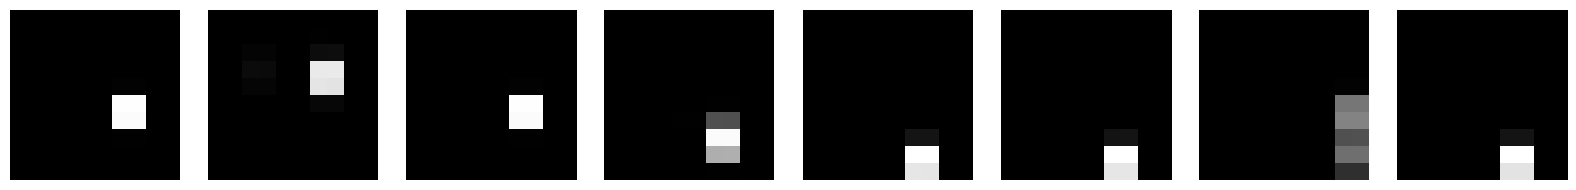

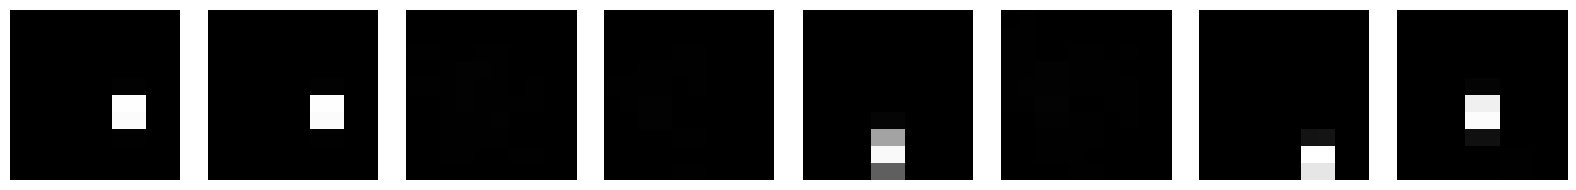

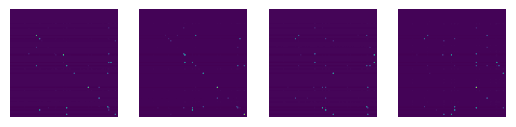

epoch 1800: 1.76


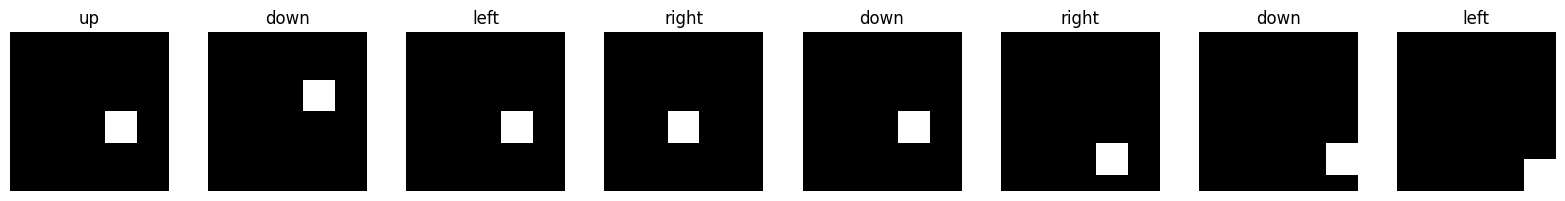

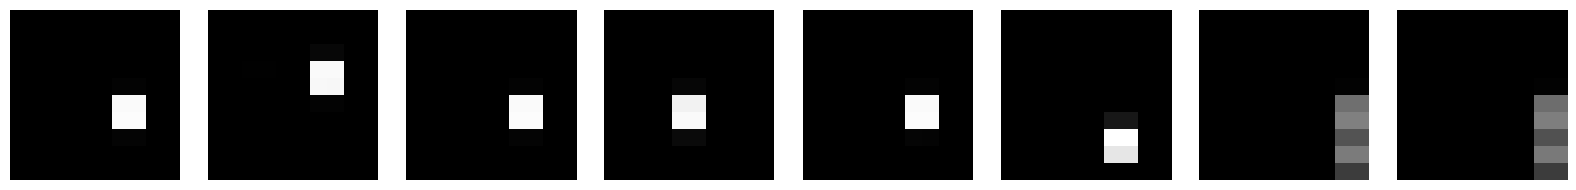

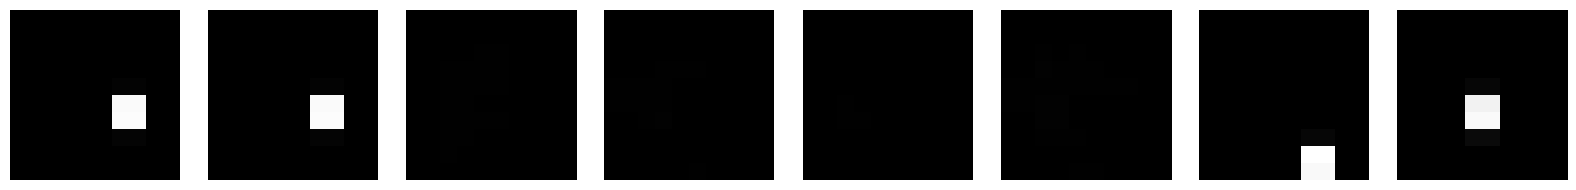

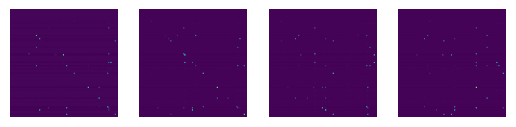

epoch 2000: 1.58


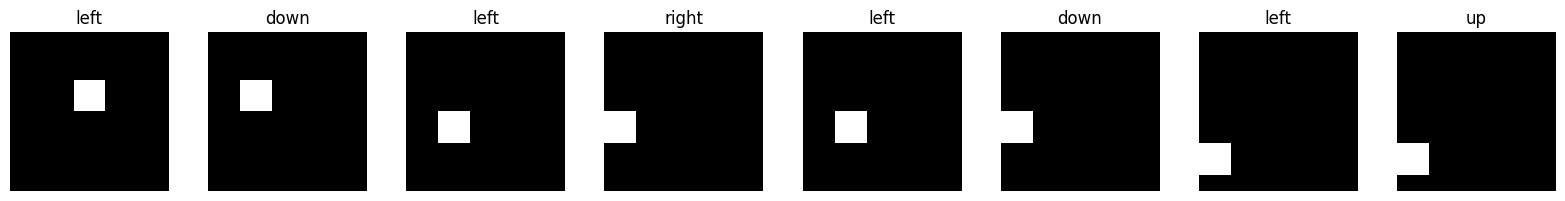

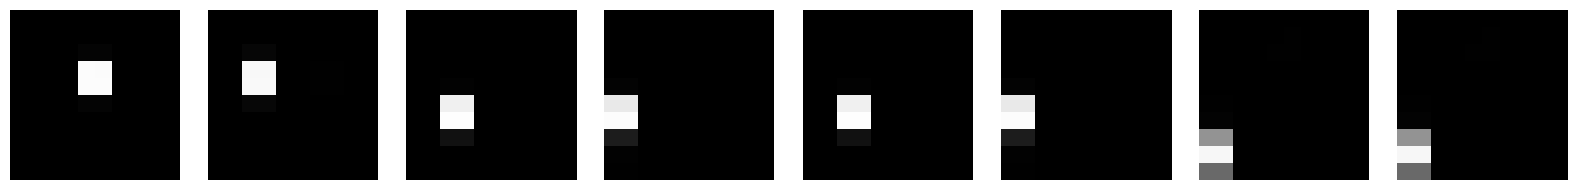

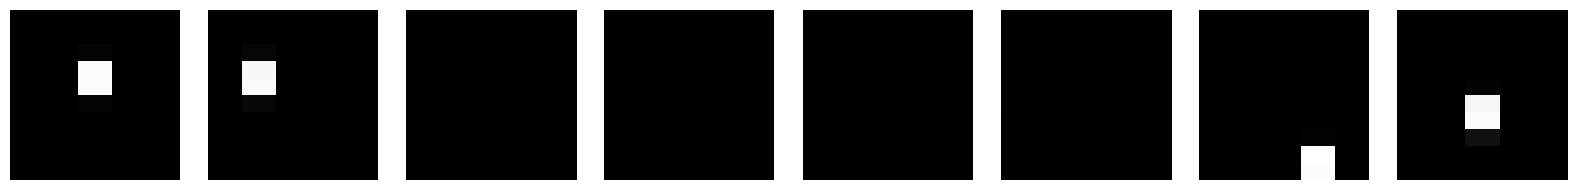

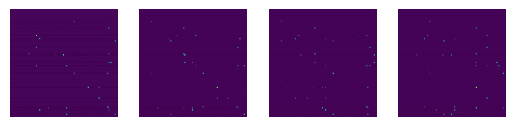

epoch 2200: 0.98


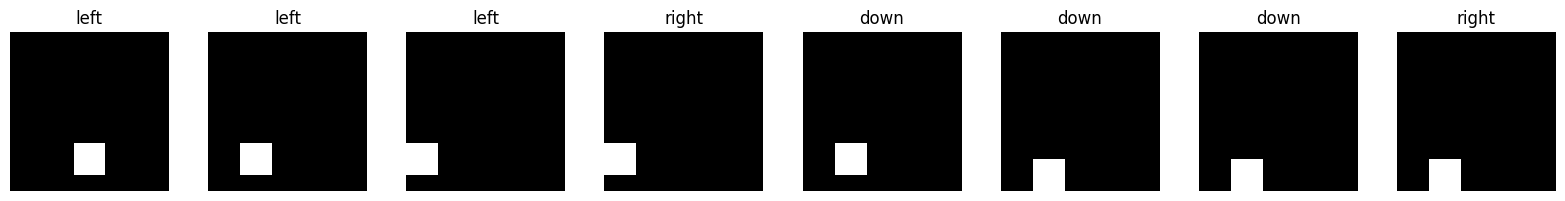

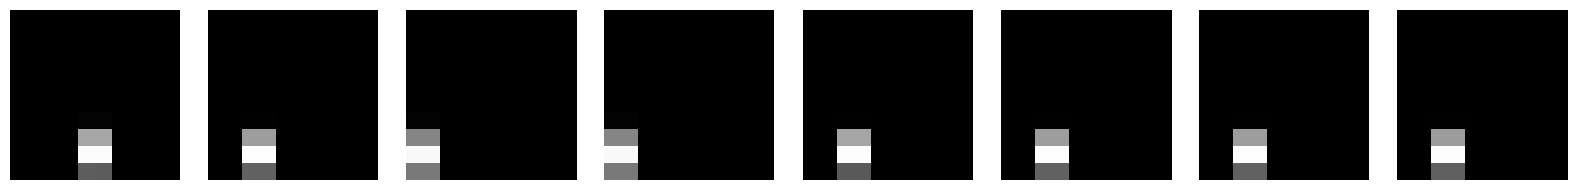

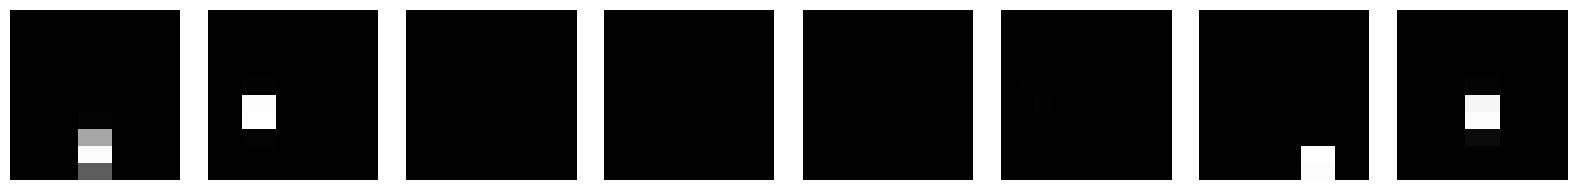

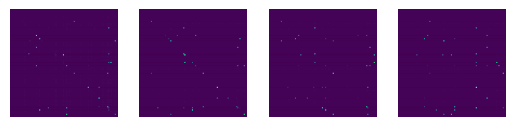

epoch 2400: 0.81


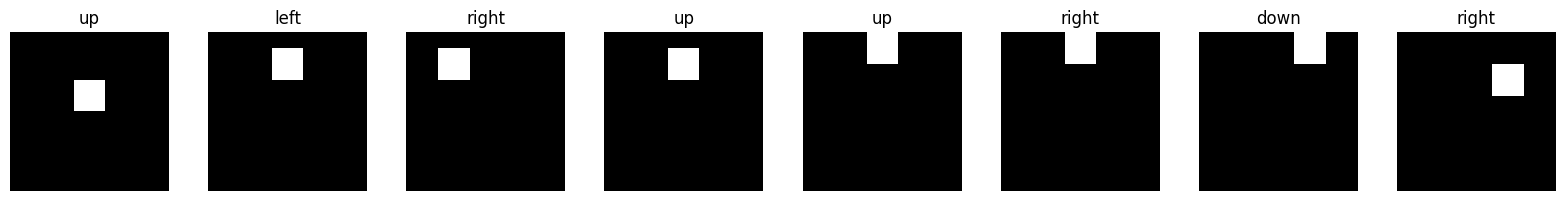

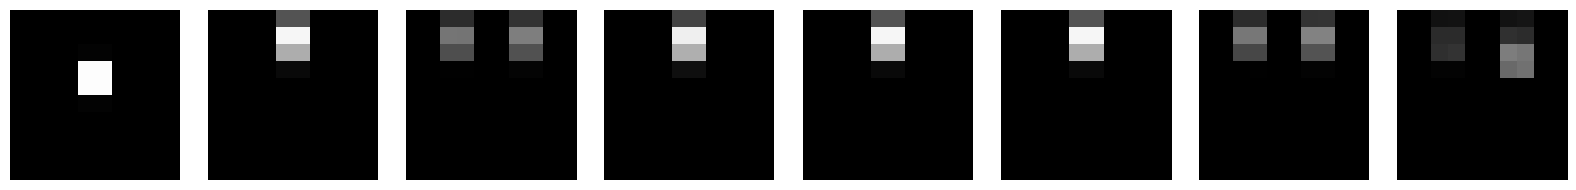

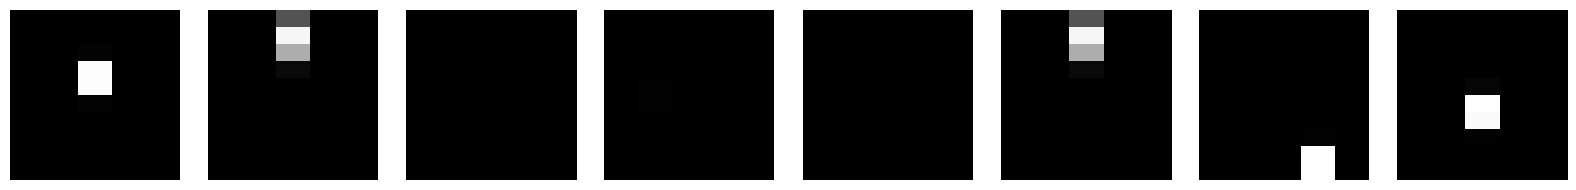

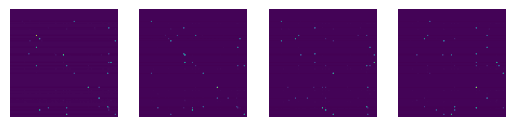

epoch 2600: 0.37


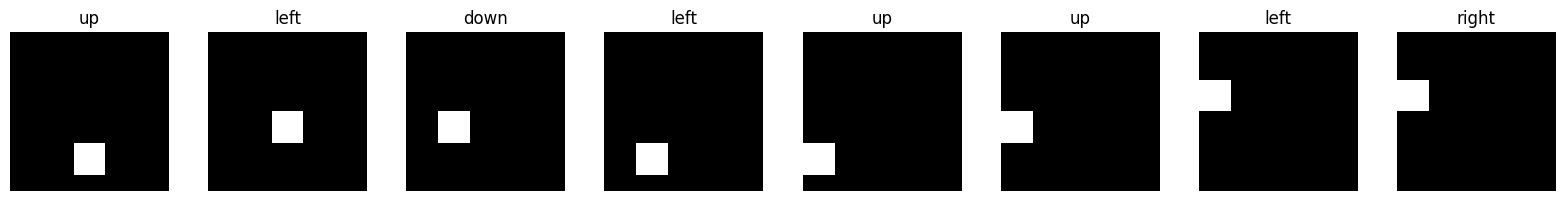

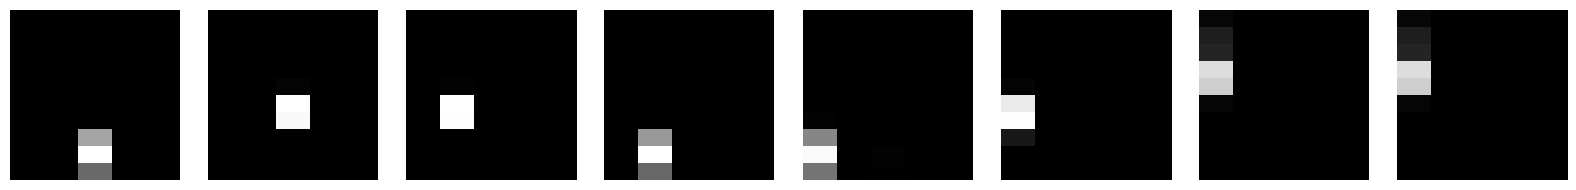

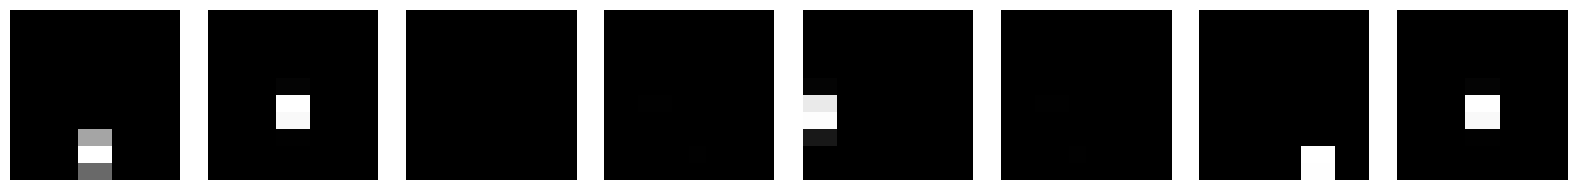

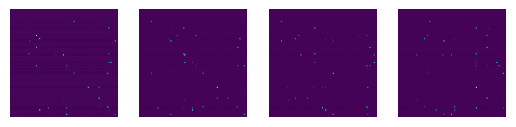

epoch 2800: -0.09


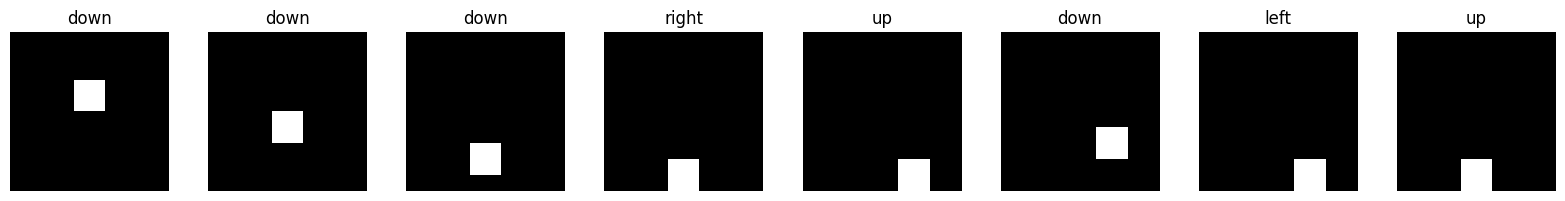

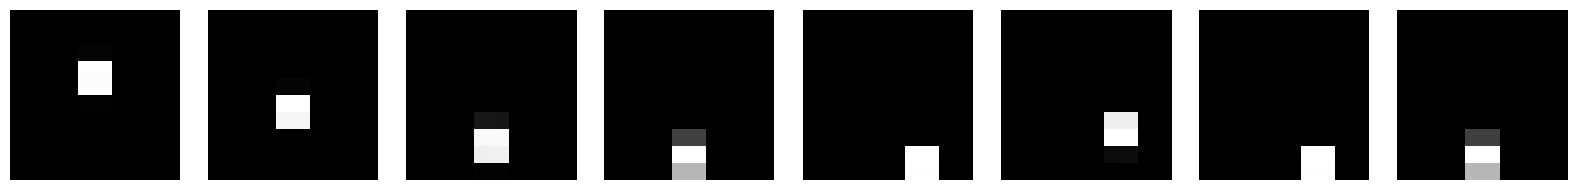

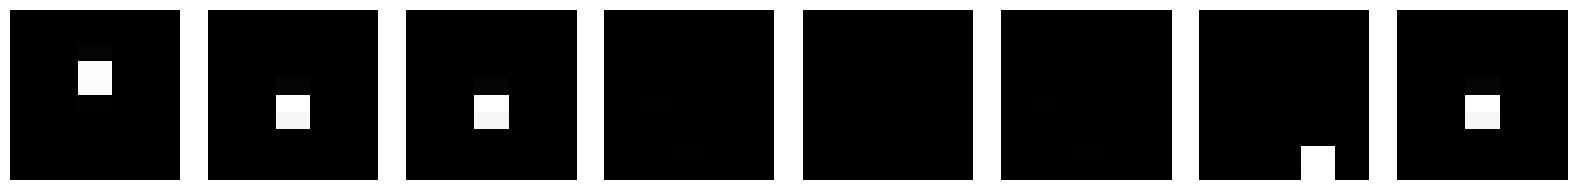

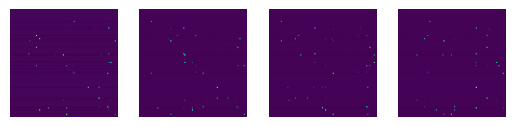

epoch 3000: -0.39


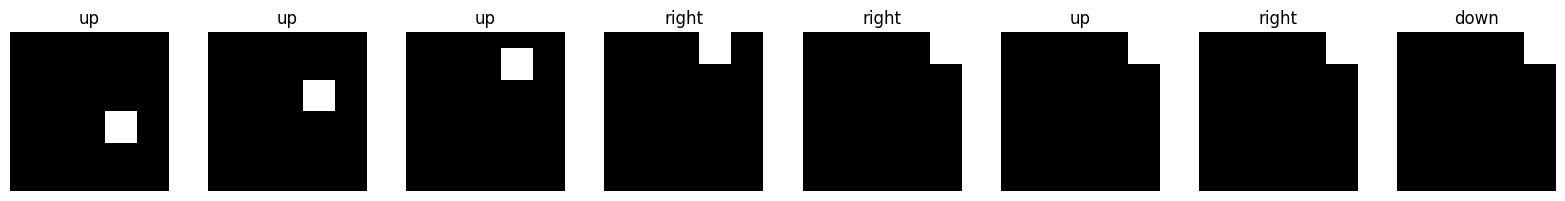

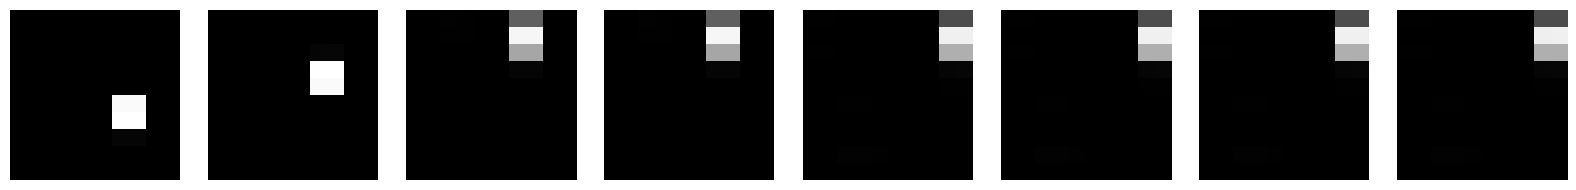

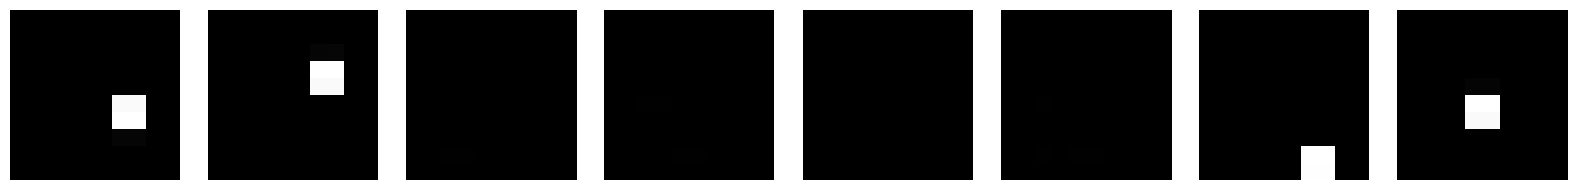

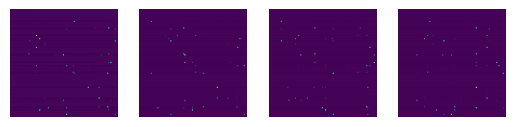

epoch 3200: -0.65


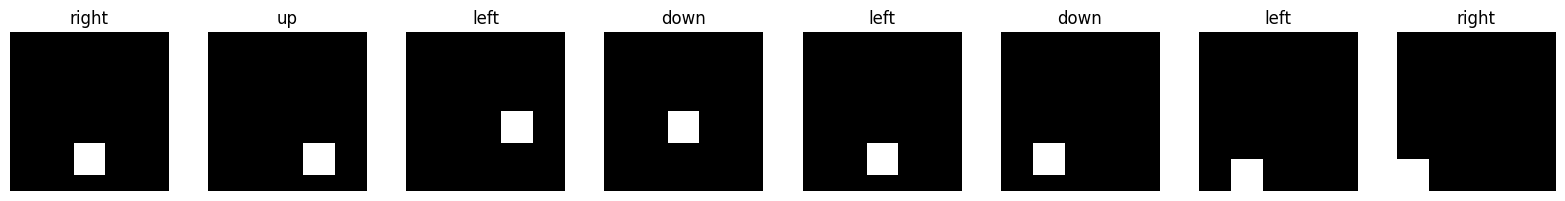

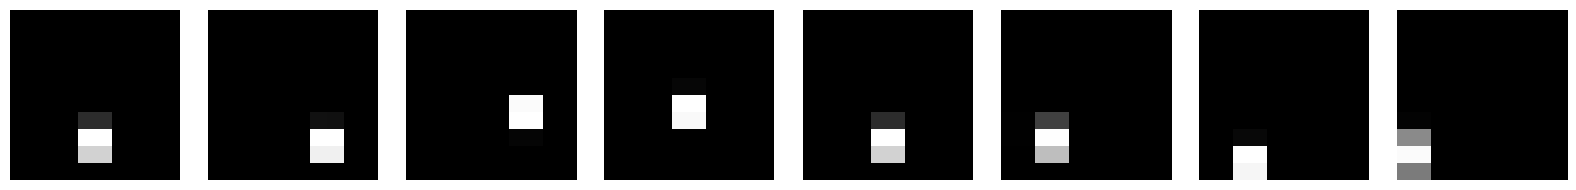

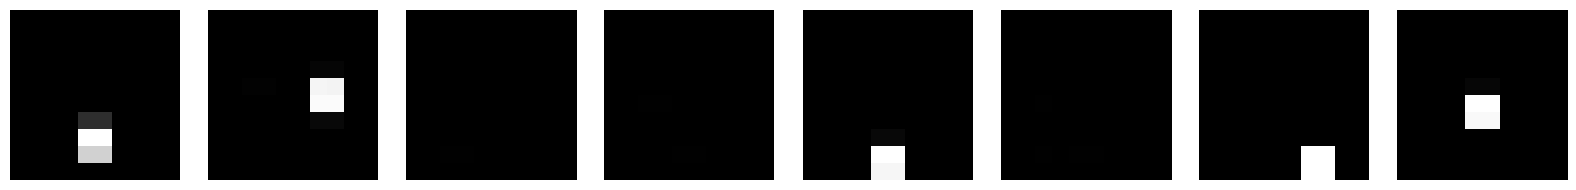

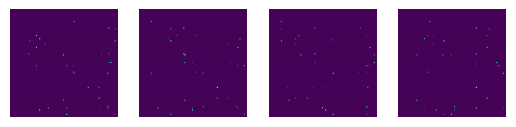

epoch 3400: -0.89


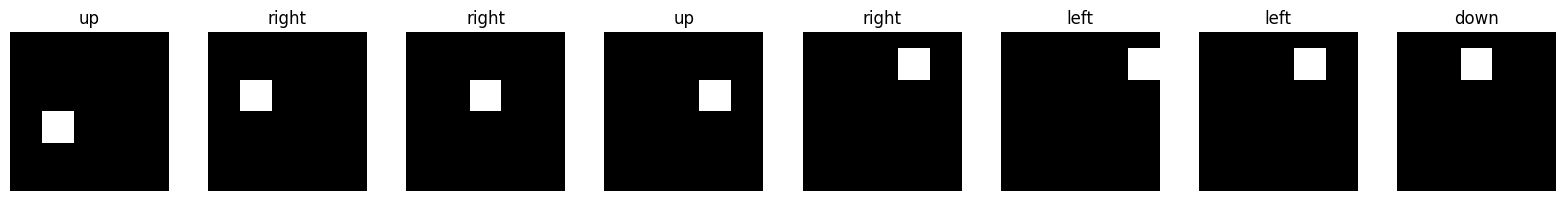

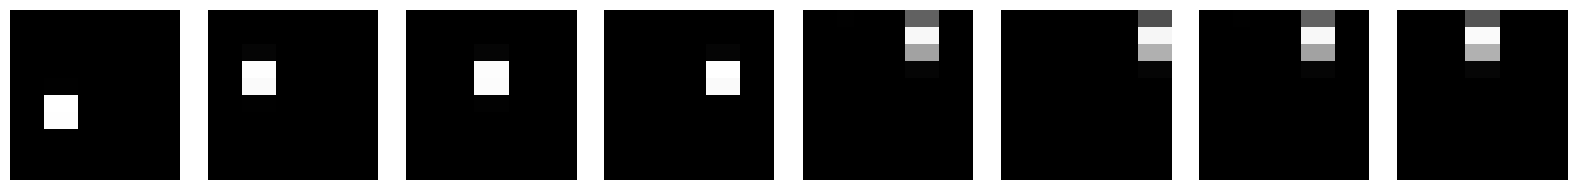

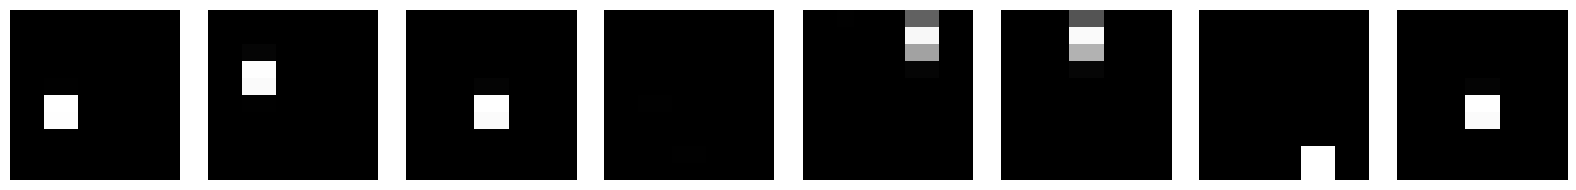

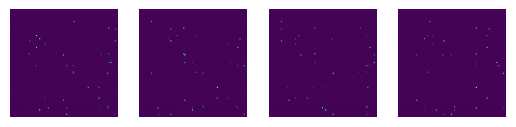

epoch 3600: -1.10


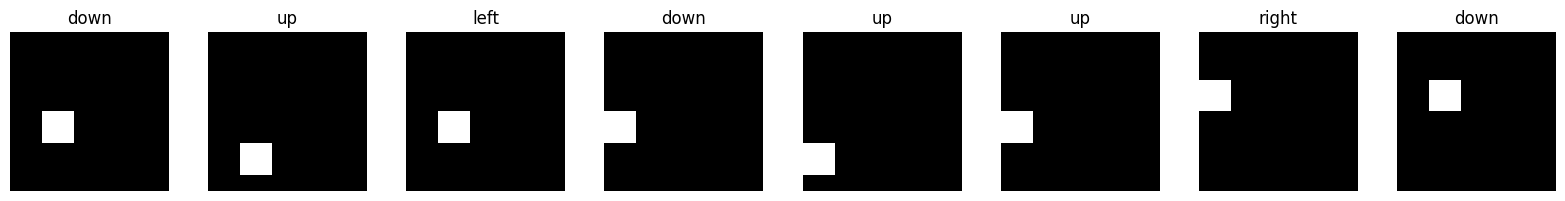

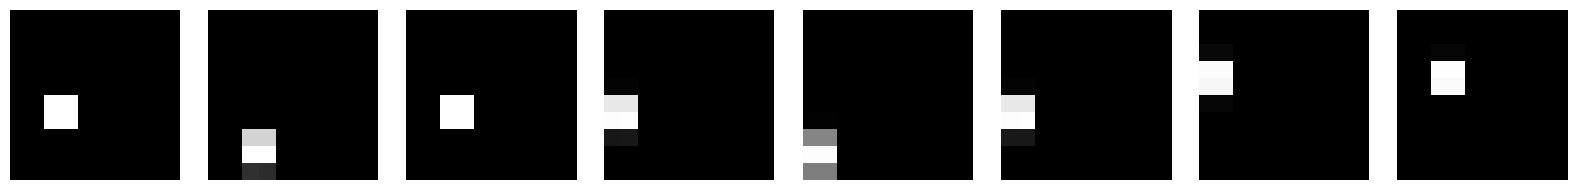

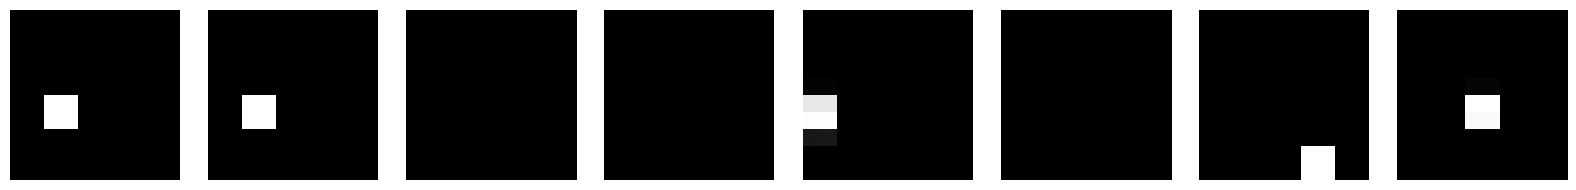

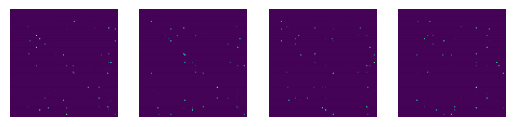

epoch 3800: -1.09


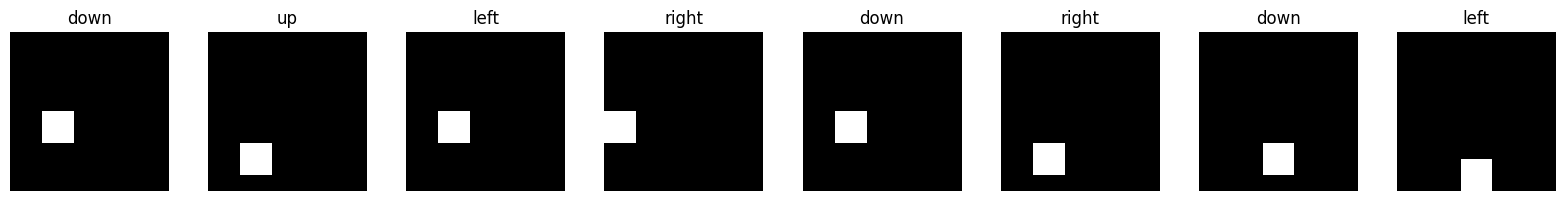

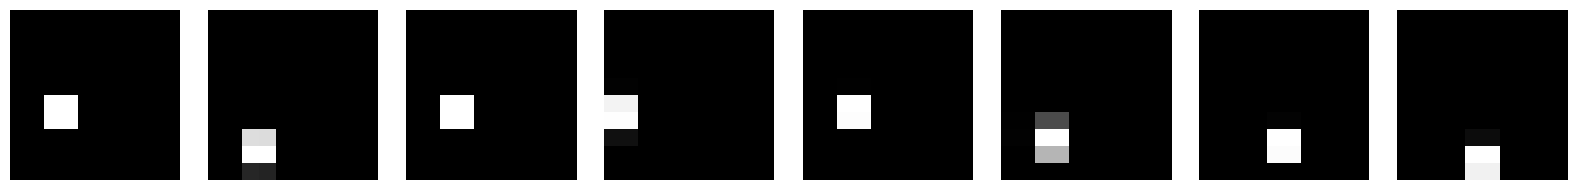

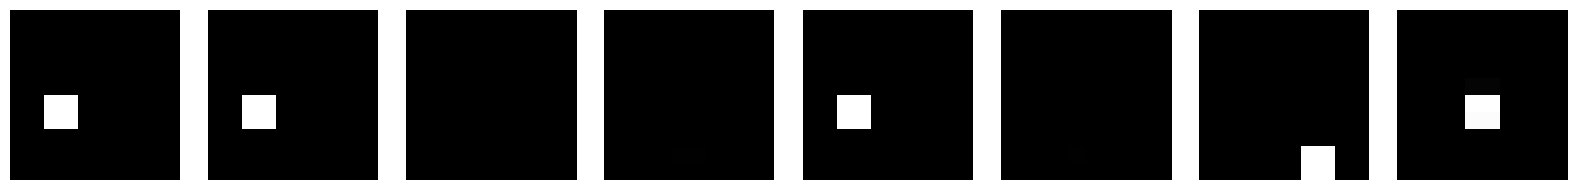

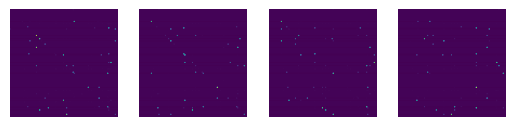

epoch 4000: -1.56


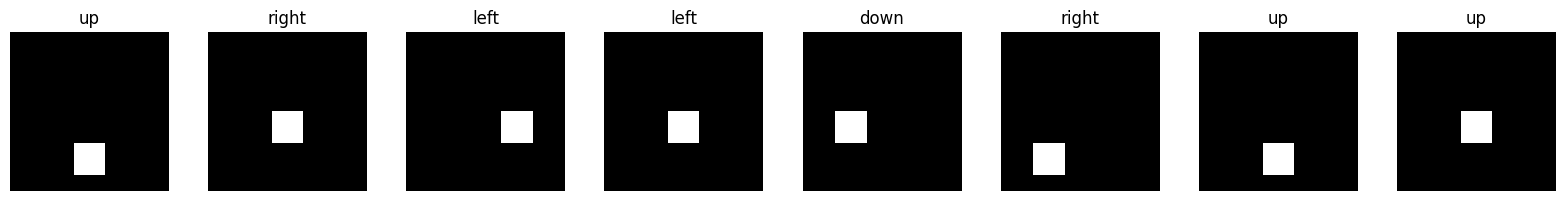

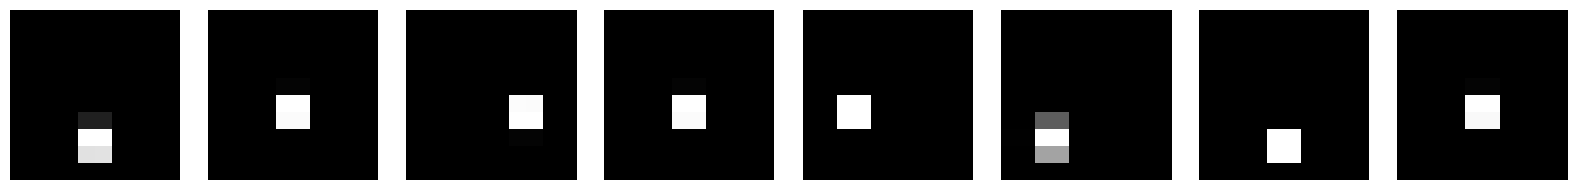

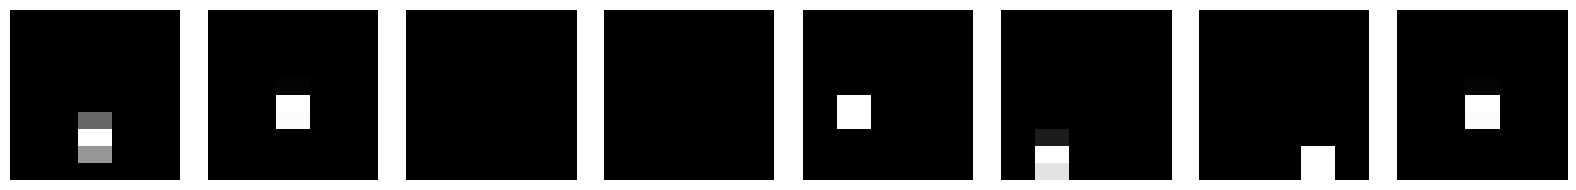

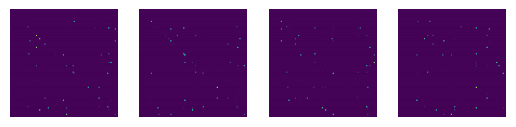

epoch 4200: -1.84


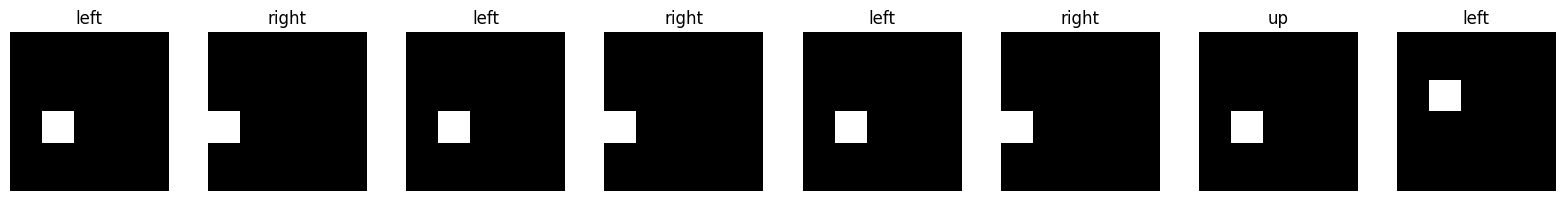

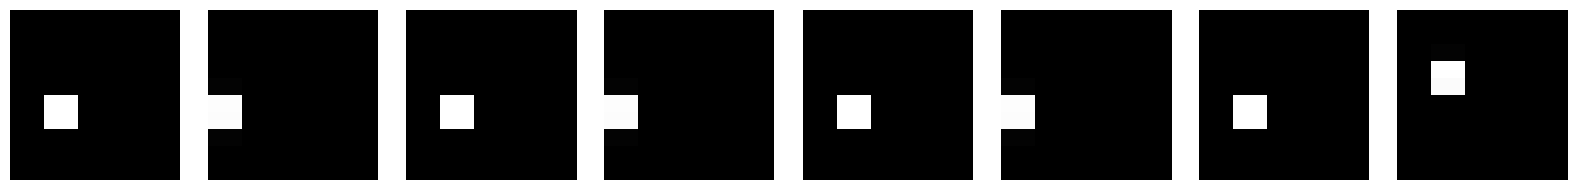

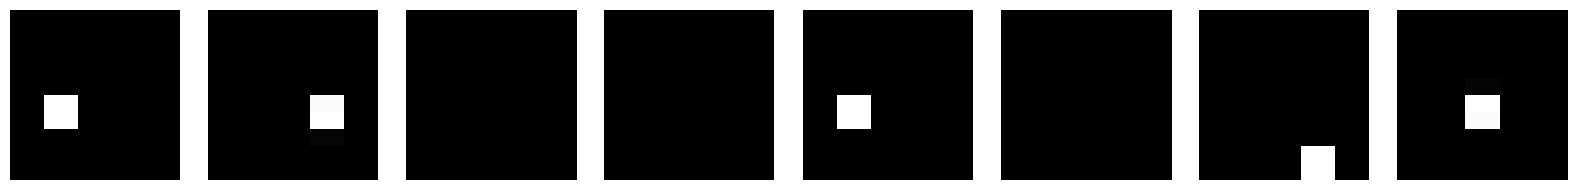

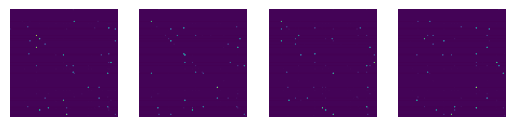

epoch 4400: -1.80


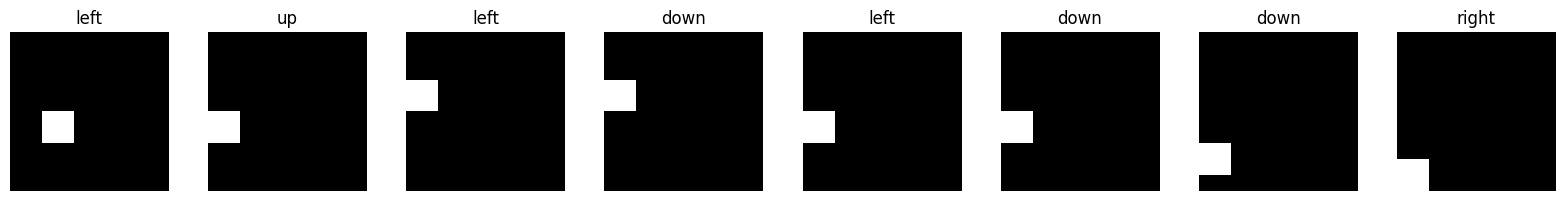

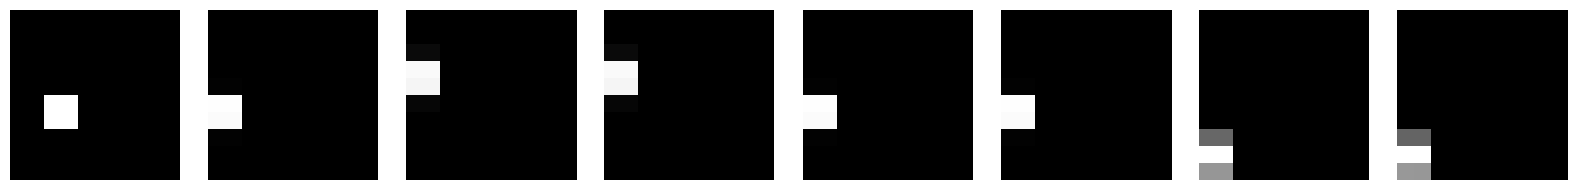

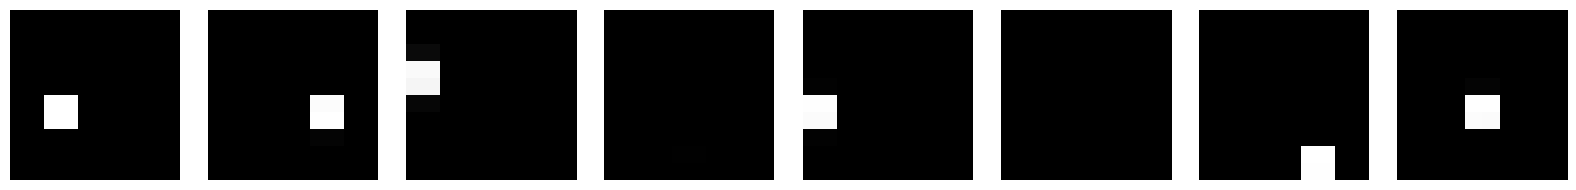

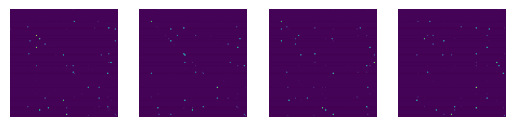

epoch 4600: -2.03


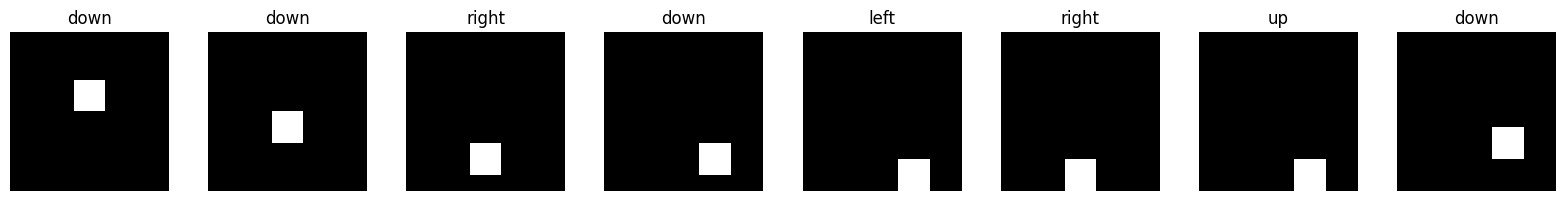

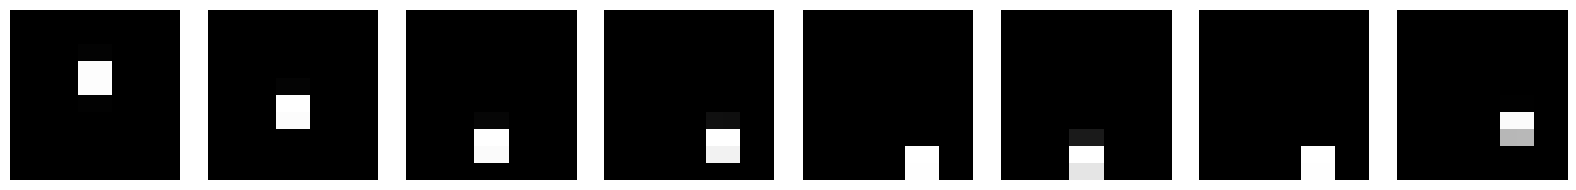

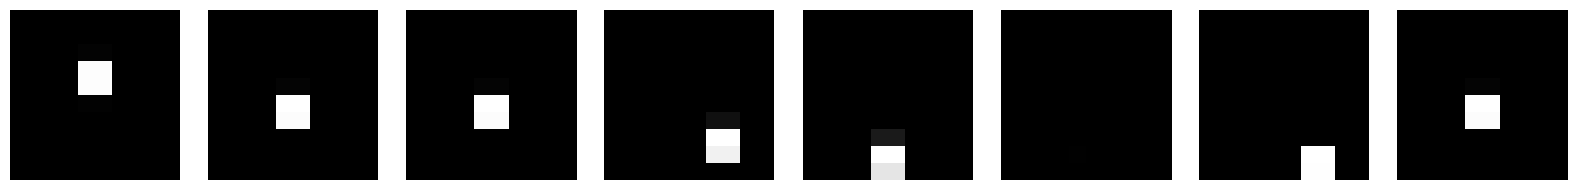

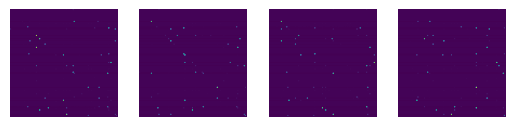

epoch 4800: nan


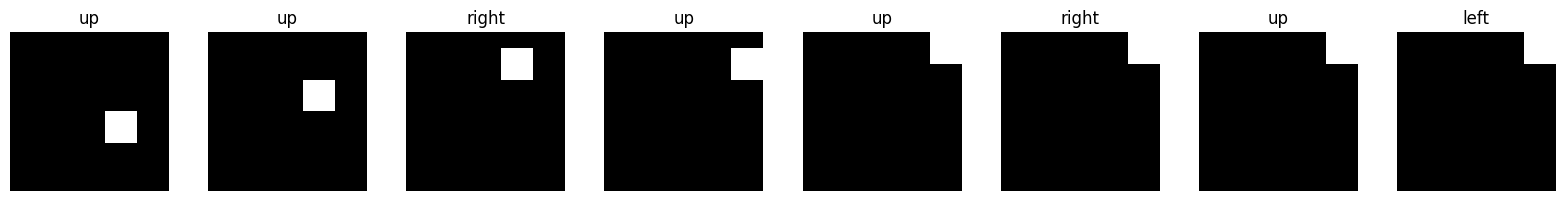

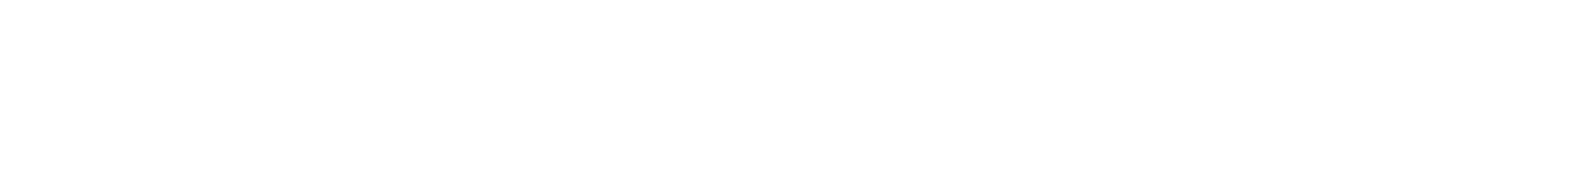

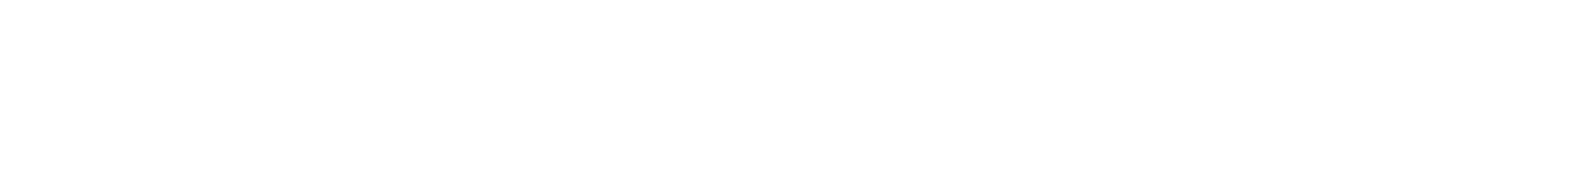

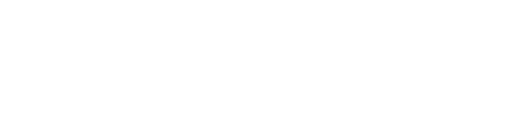

In [4]:
num_epochs = 5000
A, K, D = 4, 100, 100

prior_key, key = jr.split(key)
pgm_prior_params = init_pgm_param(prior_key, K, A, alpha=1.0)

encoder_key, key = jr.split(key)
encoder, encoder_params = init_mlp(encoder_key, D, [(512, jax.nn.relu), (K, identity)])

decoder_key, key = jr.split(key)
decoder, decoder_params = init_mlp(decoder_key, K, [(512, jax.nn.relu), (D, jax.nn.sigmoid)])
loglike = make_loglike(decoder)

pgm_key, key = jr.split(key)
pgm_params = init_pgm_param(pgm_key, K, A, alpha=1.0)

schedule = optax.linear_schedule(
    init_value=1e-3,
    end_value=1e-5,  
    transition_steps=num_epochs,  
)
pgm_optim = optax.sgd(learning_rate=1e-3)
nn_optim = optax.adamw(schedule)

pgm_opt_state = pgm_optim.init(pgm_params)
nn_opt_state = nn_optim.init((decoder_params, encoder_params))

grad_key, key = jr.split(key)
gradfun = make_gradfun(
    grad_key, run_inference, encoder, loglike, pgm_prior_params, 1, num_datapoints * num_steps, num_batches, 1e4
)

for epoch in range(num_epochs):
    (pgm_grads, decoder_grads, encoder_grads), elbo = gradfun((pgm_params, decoder_params, encoder_params), get_batch(epoch), get_action_batch(epoch))

    pgm_updates, pgm_opt_state = pgm_optim.update(pgm_grads, pgm_opt_state, pgm_params)
    nn_updates, nn_opt_state = nn_optim.update(
        (decoder_grads, encoder_grads), nn_opt_state, (decoder_params, encoder_params)
    )

    pgm_params = optax.apply_updates(pgm_params, pgm_updates)
    (decoder_params, encoder_params) = optax.apply_updates((decoder_params, encoder_params), nn_updates)

    if epoch % 200 == 0:
        print(f"epoch {epoch}: {elbo:.2f}")
        test((pgm_params, decoder_params, encoder_params), pgm_prior_params, data, actions, env, key)